<a href="https://colab.research.google.com/github/Mohammad-H-Zahrawi/Projects/blob/main/X-ray%20Implant%20Identification/MONAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!git clone https://github.com/Project-MONAI/MONAI.git
!cd MONAI/
!pip install -e '.[all]'
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 760 kB 5.4 MB/s 
Cloning into 'MONAI'...
remote: Enumerating objects: 23702, done.
remote: Counting objects: 100% (3189/3189), done.
remote: Compressing objects: 100% (1554/1554), done.
remote: Total 23702 (delta 2089), reused 2395 (delta 1634), pack-reused 20513
Receiving objects: 100% (23702/23702), 47.09 MiB | 11.18 MiB/s, done.
Resolving deltas: 100% (18007/18007), done.
ERROR: File "setup.py" or "setup.cfg" not found. Directory cannot be installed in editable mode: /content


In [ ]:
!nvidia-smi

Fri Mar 11 10:29:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.9.dev2210
Numpy version: 1.21.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 1a660e6a7a50e985af5ff76b559baab44175438c
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.2.2
TorchVision version: 0.11.1+cu111
tqdm version: 4.63.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib
import matplotlib.image as mpimg
import cv2

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpdtajyvad


In [ ]:
# path_train = '/content/drive/MyDrive/new_data/train/'
# path_test = '/content/drive/MyDrive/new_data/test/'
# dimensions = (64, 64)
# new_path_train= '/content/drive/MyDrive/new/train/'
# new_path_test= '/content/drive/MyDrive/new/test/'

In [ ]:
# for clas in os.listdir(path_train):
#   pathlib.Path(new_path_train + clas).mkdir(parents=True, exist_ok=True) 
#   for i in os.listdir(path_train+clas):
#     img = mpimg.imread(path_train+clas+'/'+i,0)
#     new_image = cv2.resize(img, dimensions, interpolation=cv2.INTER_LINEAR)
#     cv2.imwrite(new_path_train+clas+'/'+i+'.jpg',new_image)

In [ ]:
# for clas in os.listdir(path_test):
  
#   pathlib.Path(new_path_test + clas).mkdir(parents=True, exist_ok=True) 
#   for i in os.listdir(path_test+clas):
#     img = mpimg.imread(path_test+clas+'/'+i,0)
#     new_image = cv2.resize(img, dimensions, interpolation=cv2.INTER_LINEAR)
#     cv2.imwrite(new_path_test+clas+'/'+i+'.jpg',new_image)

In [ ]:

data_dir_train = "/content/drive/MyDrive/new/train"

In [ ]:
class_names = sorted(x for x in os.listdir(data_dir_train)
                     if os.path.isdir(os.path.join(data_dir_train, x)))
num_class = len(class_names)
image_files_train = [
    [
        os.path.join(data_dir_train, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir_train, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files_train[i]) for i in range(num_class)]
image_files_list_train = []
image_class_train = []
for i in range(num_class):
    image_files_list_train.extend(image_files_train[i])
    image_class_train.extend([i] * num_each[i])
num_total = len(image_class_train)
image_width, image_height = PIL.Image.open(image_files_list_train[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 1123
Image dimensions: 64 x 64
Label names: ['Isola', 'Legacy', 'M8M10', 'Other', 'Reline', 'Viper', 'Xia']
Label counts: [66, 301, 200, 82, 83, 299, 92]


In [ ]:
data_dir_test = "/content/drive/MyDrive/new/test/"

In [ ]:
class_names = sorted(x for x in os.listdir(data_dir_test)
                     if os.path.isdir(os.path.join(data_dir_test, x)))
num_class = len(class_names)
image_files_test = [
    [
        os.path.join(data_dir_test, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir_test, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files_test[i]) for i in range(num_class)]
image_files_list_test = []
image_class_test = []
for i in range(num_class):
    image_files_list_test.extend(image_files_test[i])
    image_class_test.extend([i] * num_each[i])
num_total = len(image_class_test)
image_width, image_height = PIL.Image.open(image_files_list_test[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 132
Image dimensions: 64 x 64
Label names: ['Isola', 'Legacy', 'M8M10', 'Other', 'Reline', 'Viper', 'Xia']
Label counts: [13, 26, 11, 18, 8, 36, 20]


In [ ]:
train_transforms = Compose(
    [    
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 6, prob=0.7, keep_size=True),
        RandFlip(spatial_axis=1, prob=0.8),
        RandZoom(min_zoom=0.9, max_zoom=1.3, prob=0.7),
        EnsureType(),
        
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=num_class)])

In [ ]:
length_train = len(image_files_list_train)
indices_train = np.arange(length_train)
np.random.shuffle(indices_train)
# val_frac = 0.1
# test_frac = 0.1
length_test = len(image_files_list_test)
indices_test = np.arange(length_test)
np.random.shuffle(indices_test)

# test_split = int(test_frac * length)
# val_split = int(val_frac * length) + test_split
# test_indices = indices_test[:]
val_indices = indices_test[:]
train_indices = indices_train[:]

train_x = [image_files_list_train[i] for i in train_indices]
train_y = [image_class_train[i] for i in train_indices]
val_x = [image_files_list_test[i] for i in val_indices]
val_y = [image_class_test[i] for i in val_indices]
# test_x = [image_files_list_test[i] for i in test_indices]
# test_y = [image_class_test[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Test count: {len(val_x)}")

Training count: 1123, Test count: 132


In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = Dataset(train_x, train_y, train_transforms)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=2)

val_ds = Dataset(val_x, val_y, train_transforms)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64, num_workers=2)

# test_ds = MedNISTDataset(test_x, test_y, val_transforms)
# test_loader = torch.utils.data.DataLoader(
#     test_ds, batch_size=300, num_workers=10)

In [ ]:
from monai.networks.nets import DenseNet121
from monai.networks.nets import DenseNet264


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet264(spatial_dims=2, in_channels=1,
                    out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 15
val_interval = 1
auc_metric = ROCAUCMetric()

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/15
1/17, train_loss: 2.0991
2/17, train_loss: 2.0478
3/17, train_loss: 2.0092
4/17, train_loss: 1.9866
5/17, train_loss: 1.9486
6/17, train_loss: 1.9589
7/17, train_loss: 1.9292
8/17, train_loss: 1.9836
9/17, train_loss: 1.9285
10/17, train_loss: 1.9236
11/17, train_loss: 1.9436
12/17, train_loss: 1.8891
13/17, train_loss: 1.9118
14/17, train_loss: 1.9269
15/17, train_loss: 1.8492
16/17, train_loss: 1.9132
17/17, train_loss: 1.9664
18/17, train_loss: 1.8700
epoch 1 average loss: 1.9492
saved new best metric model
current epoch: 1 current AUC: 0.5090 current accuracy: 0.1667 best AUC: 0.5090 at epoch: 1
----------
epoch 2/15
1/17, train_loss: 1.7910
2/17, train_loss: 1.8322
3/17, train_loss: 1.8490
4/17, train_loss: 1.8882
5/17, train_loss: 1.8742
6/17, train_loss: 1.8679
7/17, train_loss: 1.8065
8/17, train_loss: 1.8387
9/17, train_loss: 1.7889
10/17, train_loss: 1.7555
11/17, train_loss: 1.7539
12/17, train_loss: 1.7798
13/17, train_loss: 1.7756
14/17, train_loss: 1

## Plot the loss and metric

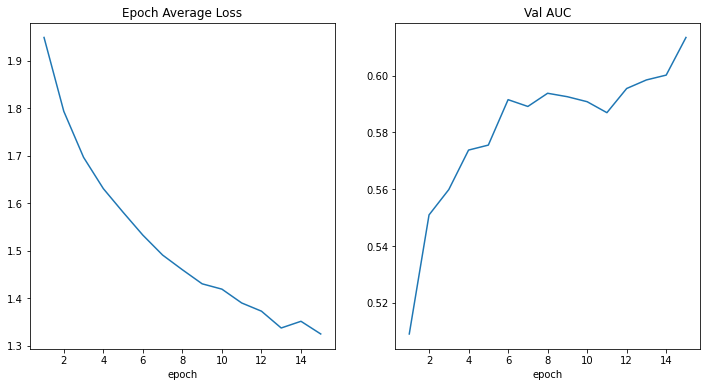

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset

After training and validation, we already got the best model on validation test.
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.
We'll use these predictions to generate a classification report.

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in val_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

       Isola     0.1818    0.1538    0.1667        13
      Legacy     0.2571    0.3462    0.2951        26
       M8M10     0.0000    0.0000    0.0000        11
       Other     0.0000    0.0000    0.0000        18
      Reline     0.0000    0.0000    0.0000         8
       Viper     0.3117    0.6667    0.4248        36
         Xia     1.0000    0.0500    0.0952        20

    accuracy                         0.2727       132
   macro avg     0.2501    0.1738    0.1403       132
weighted avg     0.3051    0.2727    0.2048       132



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Densenet264 = densenet264 = DenseNet264


In [ ]:
from monai.networks.nets import unet


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = unet
loss_function = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 3
val_interval = 1
auc_metric = ROCAUCMetric()

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/3


AttributeError: ignored